# Run FlowSOM for pixel and cell clustering

In [1]:
import harpy as hp
from harpy.datasets import pixie_example
from harpy.utils._keys import ClusteringKey

/Users/arnedf/miniconda3/envs/harpy/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


## 1. Load example dataset

In [2]:
sdata = pixie_example(["fov0", "fov1"])
sdata

/Users/arnedf/miniconda3/envs/harpy/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-03-20 13:58:50,582 - harpy.image._manager - INFO - Writing results to layer 'raw_image_fov0'
2025-03-20 13:58:50,588 - harpy.image._manager - INFO - Writing results to layer 'label_nuclear_fov0'
2025-03-20 13:58:50,593 - harpy.image._manager - INFO - Writing results to layer 'label_whole_fov0'


/Users/arnedf/.cache/huggingface/datasets/downloads/extracted/ed276a09a07145a5c25cd3c0a3fd99368fc2f3387300f55927c0b600c043de39/post_clustering


2025-03-20 13:58:50,712 - harpy.image._manager - INFO - Writing results to layer 'raw_image_fov1'
2025-03-20 13:58:50,719 - harpy.image._manager - INFO - Writing results to layer 'label_nuclear_fov1'
2025-03-20 13:58:50,726 - harpy.image._manager - INFO - Writing results to layer 'label_whole_fov1'
/Users/arnedf/miniconda3/envs/harpy/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/arnedf/miniconda3/envs/harpy/lib/python3.10/site-packages/spatialdata/models/models.py:1051: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[cls.ATTRS_KEY] = attr


SpatialData object
├── Images
│     ├── 'raw_image_fov0': DataArray[cyx] (22, 512, 512)
│     └── 'raw_image_fov1': DataArray[cyx] (22, 1024, 1024)
├── Labels
│     ├── 'label_nuclear_fov0': DataArray[yx] (512, 512)
│     ├── 'label_nuclear_fov1': DataArray[yx] (1024, 1024)
│     ├── 'label_whole_fov0': DataArray[yx] (512, 512)
│     └── 'label_whole_fov1': DataArray[yx] (1024, 1024)
└── Tables
      └── 'table': AnnData (1414, 22)
with coordinate systems:
    ▸ 'fov0', with elements:
        raw_image_fov0 (Images), label_nuclear_fov0 (Labels), label_whole_fov0 (Labels)
    ▸ 'fov1', with elements:
        raw_image_fov1 (Images), label_nuclear_fov1 (Labels), label_whole_fov1 (Labels)

In [3]:
channels = [
    "CD3",
    "CD4",
    "CD8",
    "CD14",
    "CD20",
    "CD31",
    "CD45",
    "CD68",
    "CD163",
    "CK17",
    "Collagen1",
    "Fibronectin",
    "ECAD",
    "HLADR",
    "SMA",
    "Vim",
]

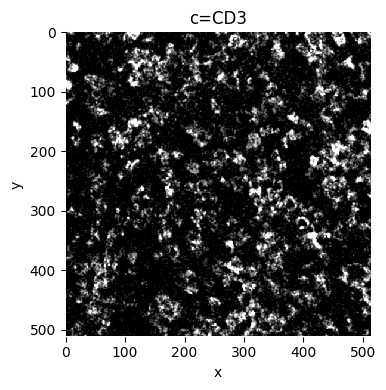

In [4]:
hp.pl.plot_image(sdata, img_layer="raw_image_fov0", to_coordinate_system="fov0", channel="CD3", figsize=(4, 4))

<Axes: title={'center': 'CD3'}, xlabel='Intensity', ylabel='Frequency'>

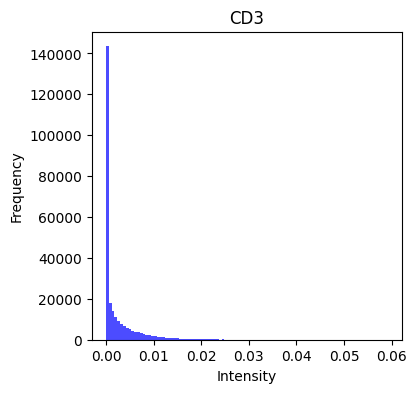

In [5]:
hp.pl.histogram(
    sdata,
    img_layer="raw_image_fov0",
    channel="CD3",
    bins=100,
    fig_kwargs={
        "figsize": (4, 4),
    },
)

## 2. Preprocess

In [6]:
sdata = hp.im.pixel_clustering_preprocess(
    sdata,
    img_layer=["raw_image_fov0", "raw_image_fov1"],
    output_layer=["raw_image_fov0_processed", "raw_image_fov1_processed"],
    channels=channels,
    chunks=2048,
    persist_intermediate=True,  # set to False if you have multiple images, and if they are large.
    overwrite=True,
    sigma=2.0,
)

2025-03-20 13:58:52,437 - harpy.image._manager - INFO - Writing results to layer 'raw_image_fov0_processed'
2025-03-20 13:58:52,444 - harpy.image._manager - INFO - Writing results to layer 'raw_image_fov1_processed'


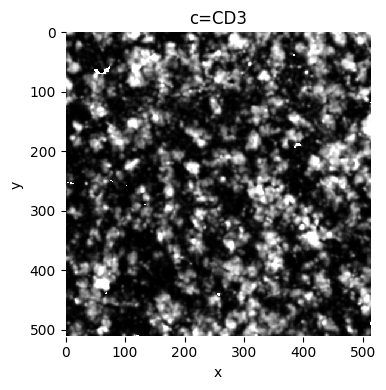

In [7]:
hp.pl.plot_image(
    sdata, img_layer="raw_image_fov0_processed", to_coordinate_system="fov0", channel="CD3", figsize=(4, 4)
)

<Axes: title={'center': 'CD3'}, xlabel='Intensity', ylabel='Frequency'>

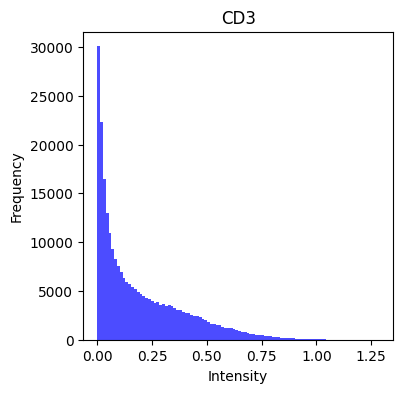

In [8]:
hp.pl.histogram(
    sdata,
    img_layer="raw_image_fov0_processed",
    channel="CD3",
    bins=100,
    fig_kwargs={
        "figsize": (4, 4),
    },
)

## 3. Pixel clustering

In [9]:
import flowsom as fs
from dask.distributed import Client, LocalCluster

work_with_client = False

if work_with_client:
    # client example
    cluster = LocalCluster(
        n_workers=1,
        threads_per_worker=10,
    )

    client = Client(cluster)
else:
    client = None

batch_model = fs.models.BatchFlowSOMEstimator

sdata, fsom, mapping = hp.im.flowsom(
    sdata,
    img_layer=["raw_image_fov0_processed", "raw_image_fov1_processed"],
    output_layer_clusters=[
        "raw_image_fov0_flowsom_clusters",
        "raw_image_fov1_flowsom_clusters",
    ],  # we need output_cluster_layer and output_meta_cluster_layer --> these will both be labels layers
    output_layer_metaclusters=[
        "raw_image_fov0_flowsom_metaclusters",
        "raw_image_fov1_flowsom_metaclusters",
    ],
    n_clusters=20,
    random_state=111,
    chunks=512,
    client=client,
    model=batch_model,
    num_batches=10,
    xdim=10,
    ydim=10,
    z_score=True,
    z_cap=3,
    persist_intermediate=True,
    overwrite=True,
)

2025-03-20 13:58:52,752 - harpy.image.pixel_clustering._clustering - INFO - Extracting random sample for FlowSOM training.
2025-03-20 13:58:52,757 - harpy.image.pixel_clustering._clustering - INFO - Start sampling
2025-03-20 13:58:52,805 - harpy.image.pixel_clustering._clustering - INFO - Start sampling
2025-03-20 13:58:52,965 - harpy.image.pixel_clustering._clustering - INFO - Start FlowSOM training.
2025-03-20 13:58:52.971 | DEBUG    | flowsom.main:__init__:84 - Reading input.
2025-03-20 13:58:52.972 | DEBUG    | flowsom.main:__init__:86 - Fitting model: clustering and metaclustering.
2025-03-20 13:58:55.252 | DEBUG    | flowsom.main:__init__:88 - Updating derived values.
2025-03-20 13:58:55,555 - harpy.image.pixel_clustering._clustering - INFO - Finished FlowSOM training. Starting inference 
2025-03-20 13:58:55,871 - harpy.image._manager - INFO - Writing results to layer 'raw_image_fov0_flowsom_clusters'
2025-03-20 13:58:55,875 - harpy.image._manager - INFO - Writing results to laye

In [10]:
sdata = hp.tb.cluster_intensity(
    sdata,
    mapping=mapping,
    img_layer=["raw_image_fov0_processed", "raw_image_fov1_processed"],
    labels_layer=["raw_image_fov0_flowsom_clusters", "raw_image_fov1_flowsom_clusters"],
    to_coordinate_system=["fov0", "fov1"],
    output_layer="counts_clusters",
    overwrite=True,
)

2025-03-20 13:58:56,272 - harpy.table.pixel_clustering._cluster_intensity - INFO - Start allocation of intensities of image layer with name 'raw_image_fov0_processed' by labels in labels layer with name 'raw_image_fov0_flowsom_clusters'.
/Users/arnedf/VIB/harpy/src/harpy/table/_allocation_intensity.py:217: ImplicitModificationWarning: Setting element `.obsm['spatial']` of view, initializing view as actual.
  adata.obsm[_SPATIAL] = coordinates
2025-03-20 13:58:56,831 - harpy.table.pixel_clustering._cluster_intensity - INFO - End allocation of image layer with name 'raw_image_fov0_processed' and labels layer with name 'raw_image_fov0_flowsom_clusters'.
2025-03-20 13:58:56,840 - harpy.table.pixel_clustering._cluster_intensity - INFO - Start allocation of intensities of image layer with name 'raw_image_fov1_processed' by labels in labels layer with name 'raw_image_fov1_flowsom_clusters'.
/Users/arnedf/VIB/harpy/src/harpy/table/_allocation_intensity.py:217: ImplicitModificationWarning: Sett

## 4. Visualization of pixel clusters and metaclusters

INFO     Dropping coordinate system 'fov1' since it doesn't have relevant elements.                                
INFO     Dropping coordinate system 'fov1' since it doesn't have relevant elements.                                


/Users/arnedf/miniconda3/envs/harpy/lib/python3.10/site-packages/spatialdata_plot/pl/utils.py:771: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_mapping)
/Users/arnedf/miniconda3/envs/harpy/lib/python3.10/site-packages/spatialdata_plot/pl/utils.py:771: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_mapping)


<Axes: title={'center': 'fov0'}>

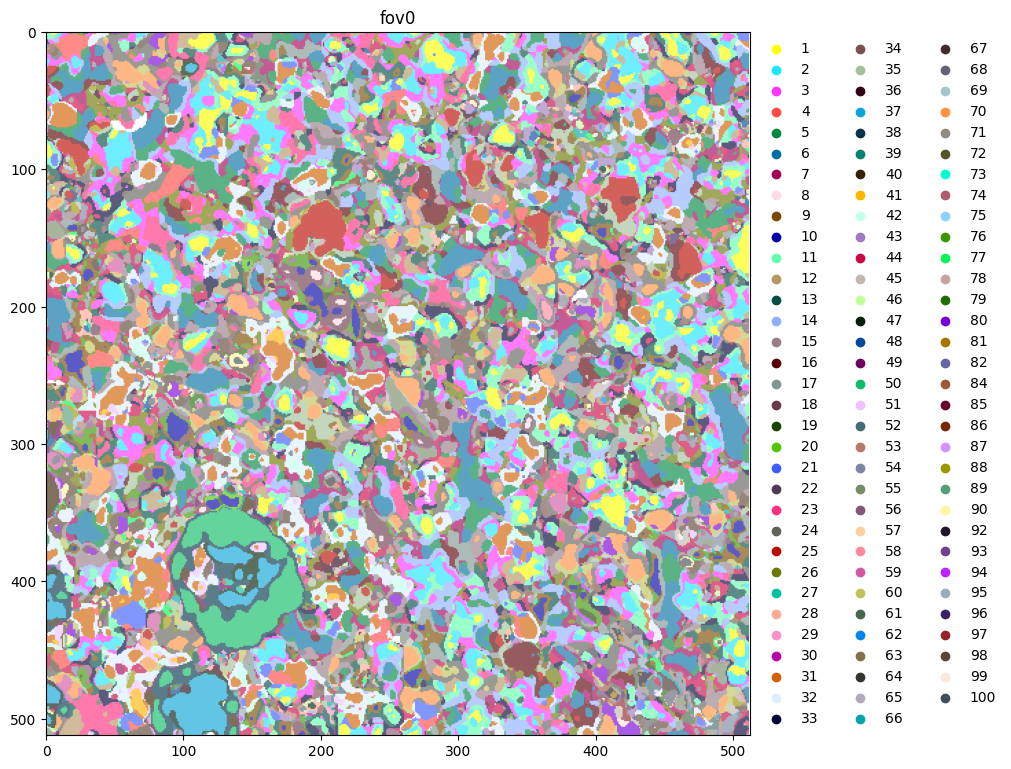

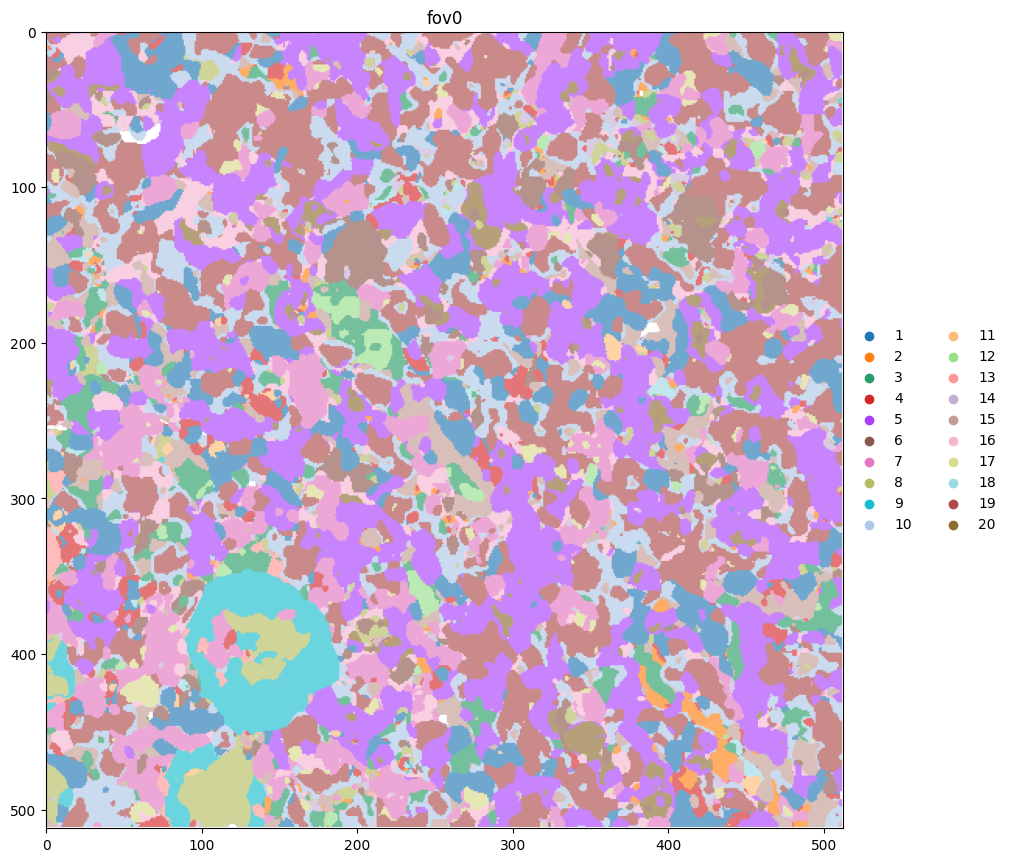

In [11]:
hp.pl.pixel_clusters(
    sdata,
    labels_layer="raw_image_fov0_flowsom_clusters",
    figsize=(10, 10),
    to_coordinate_system="fov0",
    render_labels_kwargs={"alpha": 1},
)

hp.pl.pixel_clusters(
    sdata,
    labels_layer="raw_image_fov0_flowsom_metaclusters",
    figsize=(10, 10),
    to_coordinate_system="fov0",
    render_labels_kwargs={"alpha": 1},
)

## 5. Heatmap of channel intensity per cluster and metacluster

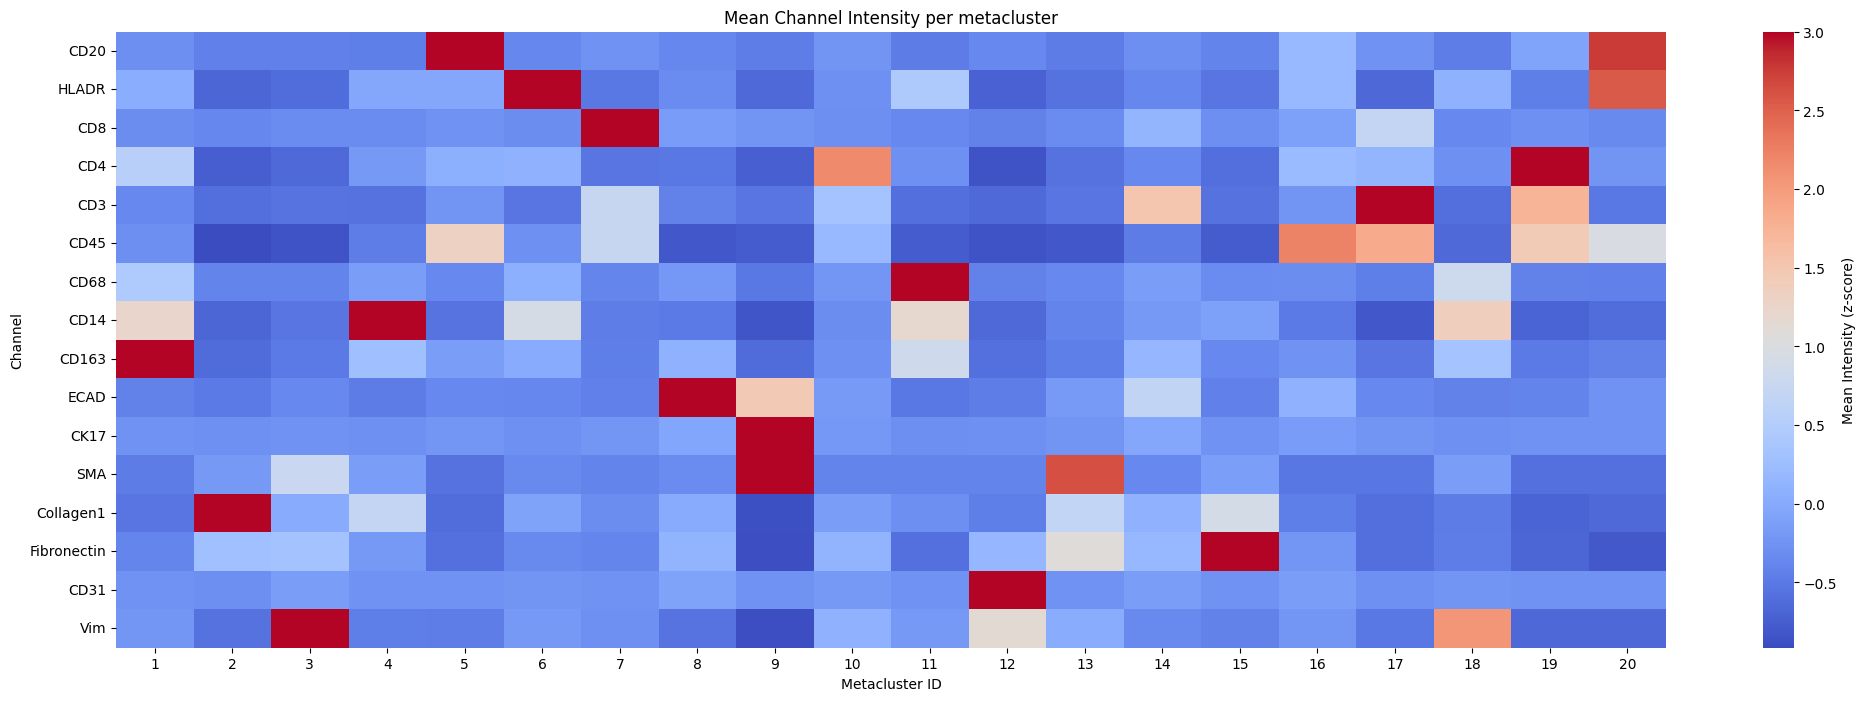

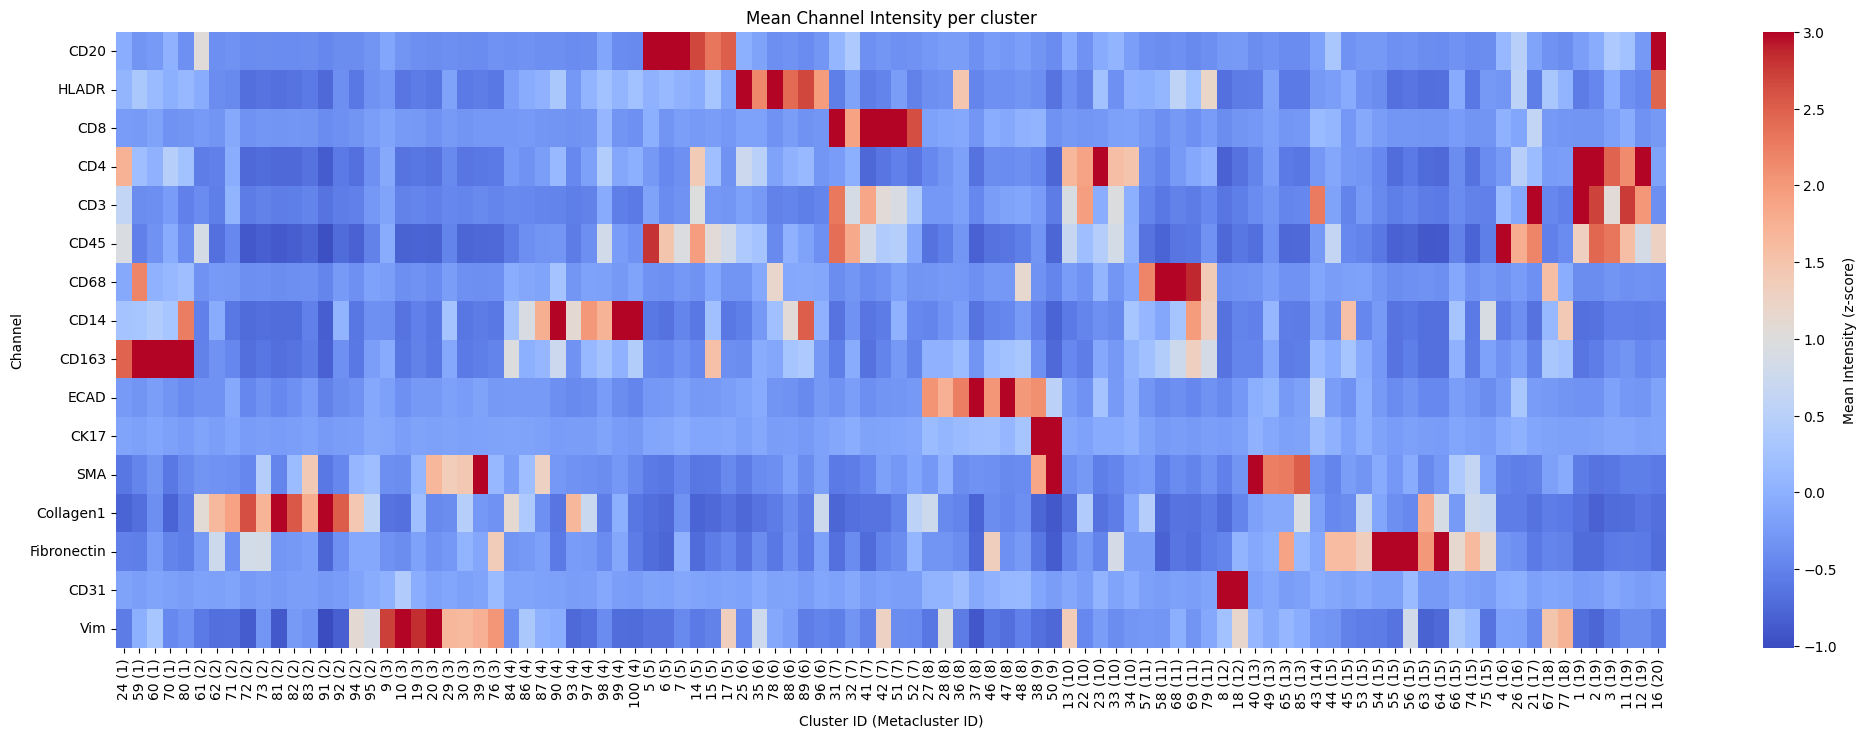

In [12]:
for _metaclusters in [True, False]:
    hp.pl.pixel_clusters_heatmap(
        sdata,
        table_layer="counts_clusters",
        figsize=(25, 8),
        fig_kwargs={"dpi": 100},
        linewidths=0.001,
        metaclusters=_metaclusters,
        z_score=True,
    )

## 6. Spatial pixel neighbors

2025-03-20 13:59:02,199 - harpy.image._manager - INFO - Writing results to layer 'labels_grid_ca0879db-0ac4-4e23-9bfa-da98e747c075'
2025-03-20 13:59:03,417 - harpy.table.pixel_clustering._neighbors - INFO - Removing layer 'labels_grid_ca0879db-0ac4-4e23-9bfa-da98e747c075' containing the spatial grid.
2025-03-20 13:59:03,417 - harpy.table.pixel_clustering._neighbors - INFO - Removing layer 'shapes_grid_ca0879db-0ac4-4e23-9bfa-da98e747c075' containing the spatial grid.
/Users/arnedf/miniconda3/envs/harpy/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
2025-03-20 13:59:03,418 - harpy.table.pixel_clustering._neighbors - INFO - Using '224' observations for neighborhood analysis.
  0%|          | 0/1000 [00:00<?, ?/s]/Users/arnedf/miniconda3/envs/harpy/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFram

/Users/arnedf/miniconda3/envs/harpy/lib/python3.10/site-packages/dask_image/ndmeasure/_utils/__init__.py:116: RuntimeWarning: invalid value encountered in scalar divide
  result["com"][0, i] = a_wt_sum_i / a_sum


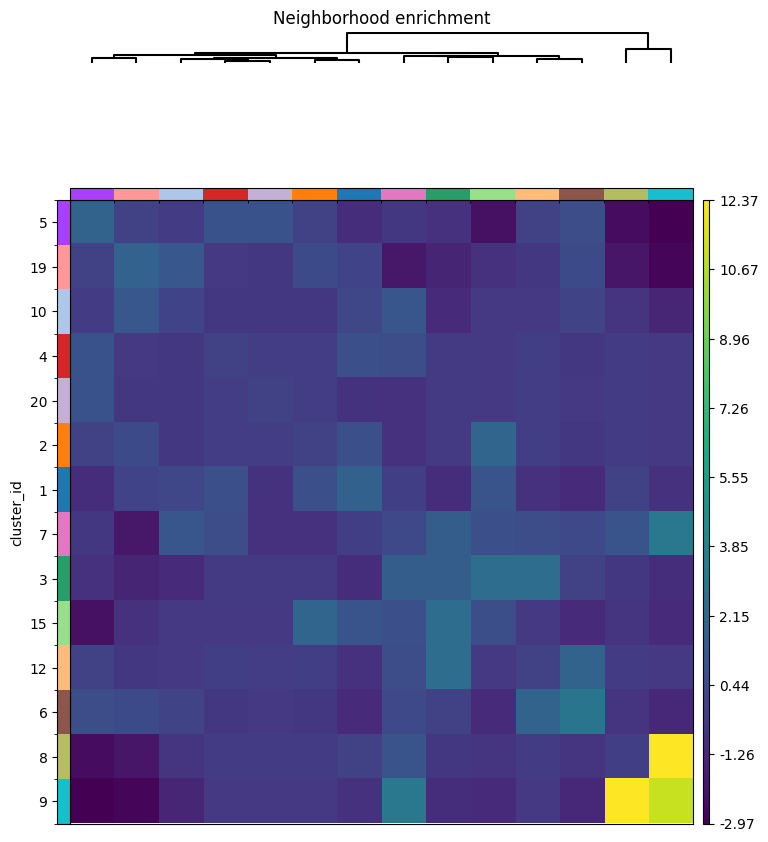

In [13]:
import numpy as np
import squidpy as sq

key_added = "cluster_id"

adata = hp.tb.spatial_pixel_neighbors(
    sdata,
    labels_layer="raw_image_fov0_flowsom_metaclusters",
    key_added=key_added,
    mode="most_frequent",
    grid_type="hexagon",
    size=20,
    subset=None,
)

adata.uns[f"{key_added}_nhood_enrichment"]["zscore"] = np.nan_to_num(
    adata.uns[f"{key_added}_nhood_enrichment"]["zscore"]
)
sq.pl.nhood_enrichment(adata, cluster_key=key_added, method="ward", mode="zscore", figsize=(8, 8))

## 7. Cell clustering

In [14]:
batch_model = fs.models.BatchFlowSOMEstimator

sdata, fsom = hp.tb.flowsom(
    sdata,
    labels_layer_cells=["label_whole_fov0", "label_whole_fov1"],
    labels_layer_clusters=[
        "raw_image_fov0_flowsom_metaclusters",
        "raw_image_fov1_flowsom_metaclusters",
    ],  # here you could also choose "ark_pixel_som_cluster"
    output_layer="table_cell_clustering_flowsom",
    chunks=512,
    model=batch_model,
    num_batches=10,
    random_state=100,
    overwrite=True,
)

2025-03-20 13:59:08,610 - harpy.table._preprocess - INFO - Calculating cell size from provided labels_layer 'label_whole_fov0'
2025-03-20 13:59:08,626 - harpy.table._preprocess - INFO - Calculating cell size from provided labels_layer 'label_whole_fov1'
/Users/arnedf/miniconda3/envs/harpy/lib/python3.10/site-packages/spatialdata/models/models.py:1053: UserWarning: Converting `region_key: fov_labels` to categorical dtype.
  return convert_region_column_to_categorical(adata)
/Users/arnedf/miniconda3/envs/harpy/lib/python3.10/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `table_cell_clustering_flowsom` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
2025-03-20 13:59:08.673 | DEBUG    | flowsom.main:__init__:84 - Reading input.
2025-03-20 13:59:08.674 | DEBUG    | flowsom.main:__init__:86 - Fitting model: clustering and metaclustering.
2025-03-20 13:59:08.681 | DEBUG    | flowsom.main:__init__:88 - Updating derived value

INFO     Dropping coordinate system 'fov1' since it doesn't have relevant elements.                                


/Users/arnedf/miniconda3/envs/harpy/lib/python3.10/site-packages/spatialdata_plot/pl/utils.py:771: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_mapping)


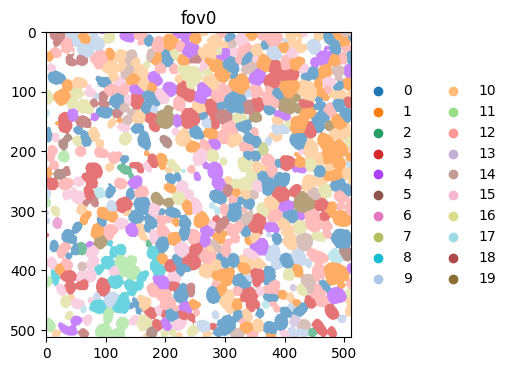

In [15]:
sdata.pl.render_labels("label_whole_fov0", table_name="table_cell_clustering_flowsom", color="metaclustering").pl.show(
    figsize=(5, 5)
)

In [16]:
# "table_cell_clustering_flowsom" is annotated by segmentation masks, so they can also be visualised using napari-spatialdata
sdata["table_cell_clustering_flowsom"].uns["spatialdata_attrs"]

# from napari_spatialdata import Interactive

# Interactive(sdata)

{'region': ['label_whole_fov0', 'label_whole_fov1'],
 'region_key': 'fov_labels',
 'instance_key': 'cell_ID'}

## Optional export to a .csv format that can be used for visualization using the ark analysis [gui](https://github.com/angelolab/ark-analysis/blob/main/templates/2_Pixie_Cluster_Pixels.ipynb)

In [17]:
# weighted channel average for visualization -> calculate this on the flowsom clustered matrix
sdata = hp.tb.weighted_channel_expression(
    sdata,
    table_layer_cell_clustering="table_cell_clustering_flowsom",
    table_layer_pixel_cluster_intensity="counts_clusters",
    output_layer="table_cell_clustering_flowsom",
    clustering_key=ClusteringKey._METACLUSTERING_KEY,
    overwrite=True,
)

2025-03-20 13:59:09,293 - harpy.table.cell_clustering._weighted_channel_expression - INFO - Adding mean over obtained cell clusters '(clustering)' of the average marker expression for each cell weighted by pixel cluster count to '.uns[ 'clustering_channels' ]' of table layer 'table_cell_clustering_flowsom'
2025-03-20 13:59:09,294 - harpy.table.cell_clustering._weighted_channel_expression - INFO - Adding mean over obtained cell clusters '(metaclustering)' of the average marker expression for each cell weighted by pixel cluster count to '.uns[ 'metaclustering_channels' ]' of table layer 'table_cell_clustering_flowsom'
2025-03-20 13:59:09,294 - harpy.table.cell_clustering._weighted_channel_expression - INFO - Adding average marker expression for each cell weighted by pixel cluster count to '.obs' of table layer 'table_cell_clustering_flowsom'
/Users/arnedf/miniconda3/envs/harpy/lib/python3.10/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `table_cell_clustering_flowsom

In [18]:
from harpy.table.cell_clustering._utils import _export_to_ark_format as _export_to_ark_format_cells
from harpy.table.pixel_clustering._cluster_intensity import _export_to_ark_format as _export_to_ark_format_pixels

df = _export_to_ark_format_pixels(adata=sdata["counts_clusters"], output=None)
(
    df_cell_som_cluster_count_avg,
    df_cell_som_cluster_channel_avg,
    df_cell_meta_cluster_channel_avg,
) = _export_to_ark_format_cells(sdata, table_layer="table_cell_clustering_flowsom", output=None)
df.head()

2025-03-20 13:59:09,372 - harpy.table.cell_clustering._utils - WARNING - Increasing cell cluster IDs (SOM cluster and meta cluster IDs) with +1 for visualization. The underlying dataframe in the SpatialData object remains unchanges.
2025-03-20 13:59:09,373 - harpy.table.cell_clustering._utils - WARNING - Increasing cell cluster IDs (SOM cluster and meta cluster IDs) with +1 for visualization. The underlying dataframe in the SpatialData object remains unchanges.
2025-03-20 13:59:09,374 - harpy.table.cell_clustering._utils - WARNING - Increasing cell cluster IDs (SOM cluster and meta cluster IDs) with +1 for visualization. The underlying dataframe in the SpatialData object remains unchanges.


channels,CD3,CD4,CD8,CD14,CD20,CD31,CD45,CD68,CD163,CK17,Collagen1,Fibronectin,ECAD,HLADR,SMA,Vim,pixel_meta_cluster,pixel_som_cluster,count
cells,,,,,,,,,,,,,,,,,,,
1_counts_clusters_6d4e77c5,78.213259,61.126751,2.457998,4.252463,3.446840,0.554674,37.530334,1.951818,2.772218,1.666862,7.613220,4.601224,2.113589,2.418919,1.266339,6.041482,19,1,11036
2_counts_clusters_6d4e77c5,50.153395,67.441124,2.518237,4.672456,5.364604,0.854113,55.720462,1.958150,3.671581,1.909836,4.311390,4.442934,2.173484,3.777171,0.336558,4.778424,19,2,11467
3_counts_clusters_6d4e77c5,25.904392,50.320876,4.003588,7.159154,10.465461,2.101079,53.859821,3.193832,5.496780,2.506698,6.470698,6.536502,4.148207,8.694393,0.643699,8.216018,19,3,15124
4_counts_clusters_6d4e77c5,12.340430,10.125952,6.663111,6.697139,7.390209,2.736008,83.150284,2.986983,5.889276,3.187898,10.668278,10.737763,3.198280,5.538354,2.472869,13.428594,16,4,6108
5_counts_clusters_6d4e77c5,8.050895,10.003621,6.517391,5.748279,52.937352,1.318856,61.604550,2.566309,4.957811,2.393520,7.181328,4.803185,2.919045,9.444406,1.024099,6.564786,5,5,13677


In [19]:
df_cell_meta_cluster_channel_avg.head()

channels,cell_meta_cluster,CD3,CD4,CD8,CD14,CD20,CD31,CD45,CD68,CD163,CK17,Collagen1,Fibronectin,ECAD,HLADR,SMA,Vim,cell_meta_cluster_rename
0,1,13.166177,17.529019,7.244892,11.225361,28.691100,2.187957,34.097203,4.251078,9.459652,2.645420,13.189971,9.362344,3.817631,11.277956,3.112404,12.296237,1
1,2,24.736702,31.700507,5.672960,10.798915,15.144748,1.706095,34.435184,4.424383,8.617183,2.455735,12.106629,9.609483,3.906555,8.471367,2.886642,11.952189,2
2,3,5.430960,11.986036,4.077311,35.614439,2.502254,1.615006,12.354145,8.908025,12.849534,1.661143,25.794578,12.554322,2.721787,9.099934,7.359458,13.431340,3
3,4,8.010036,7.865185,5.919491,9.387123,4.149832,3.010460,11.473369,4.084447,5.848284,1.832650,13.332829,9.238094,4.913494,5.604768,4.483465,10.170900,4
4,5,21.231135,33.300189,4.491006,12.852755,6.323750,2.052127,25.316769,5.373582,8.770902,2.864071,17.088658,12.085506,4.641196,8.007934,4.720307,15.118291,5
